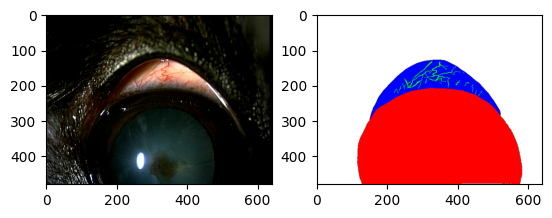

In [1]:
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt

mode = 'train'
ID = '0003'

eye_img = np.array(Image.open(f'data/{mode}/image/{ID}.png').convert('RGB'))
mask_img = np.array(Image.open(f'data/{mode}/label/{ID}.png'))

plt.subplot(1, 2, 1)
plt.imshow(eye_img)
plt.subplot(1, 2, 2)
plt.imshow(mask_img)
plt.show()

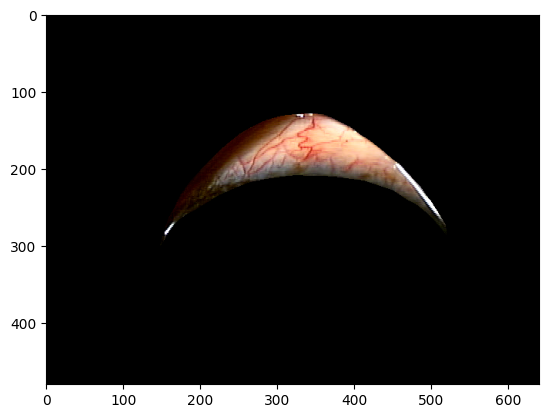

In [2]:
blue_mask = cv2.inRange(mask_img, np.array([0, 0, 255, 255]), np.array([0, 0, 255, 255]))
green_mask = cv2.inRange(mask_img, np.array([0, 255, 0, 255]), np.array([0, 255, 0, 255]))
conj_mask = green_mask | blue_mask
conj_mask = cv2.cvtColor(conj_mask, cv2.COLOR_GRAY2RGB)

conj_image = cv2.bitwise_and(eye_img, conj_mask)
plt.imshow(conj_image)
plt.show()

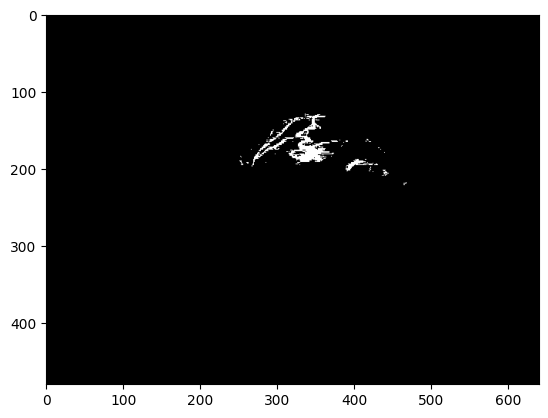

In [3]:
hsv_img = cv2.cvtColor(conj_image, cv2.COLOR_RGB2HSV)

# 赤色の範囲を定義（HSVでの赤は0付近と180付近）
lower_red1 = np.array([0, 120, 120]) 
upper_red1 = np.array([10, 255, 255])

red_mask = cv2.inRange(hsv_img, lower_red1, upper_red1)

plt.imshow(red_mask, cmap='gray')
plt.show()

In [4]:
import ipywidgets as widgets
from IPython.display import display

def update_mask(h_min, h_max, s_min, v_min):
    hsv_img = cv2.cvtColor(conj_image, cv2.COLOR_RGB2HSV)
    lower_red = np.array([h_min, s_min, v_min])
    upper_red = np.array([h_max, 255, 255])
    
    red_mask = cv2.inRange(hsv_img, lower_red, upper_red)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(conj_image)
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(red_mask, cmap='gray')
    plt.title('Red Mask')
    plt.show()

# スライダーの初期値を変更
h_min_slider = widgets.IntSlider(value=0, min=0, max=180, description='H min')
h_max_slider = widgets.IntSlider(value=10, min=0, max=180, description='H max')
s_min_slider = widgets.IntSlider(value=120, min=0, max=255, description='S min')
v_min_slider = widgets.IntSlider(value=120, min=0, max=255, description='V min')

# インタラクティブな表示を作成
widgets.interactive(update_mask, 
                   h_min=h_min_slider,
                   h_max=h_max_slider,
                   s_min=s_min_slider,
                   v_min=v_min_slider)

interactive(children=(IntSlider(value=0, description='H min', max=180), IntSlider(value=10, description='H max…

In [5]:
import ipywidgets as widgets
from IPython.display import display

def update_mask(h_min, h_max, s_min, v_min, block_size, c_value, use_adaptive):
    hsv_img = cv2.cvtColor(conj_image, cv2.COLOR_RGB2HSV)
    lower_red = np.array([h_min, s_min, v_min])
    upper_red = np.array([h_max, 255, 255])
    
    # 通常のカラーベースのマスク
    red_mask = cv2.inRange(hsv_img, lower_red, upper_red)
    
    if use_adaptive:
        # グレースケールに変換
        gray = cv2.cvtColor(conj_image, cv2.COLOR_BGR2GRAY)
        # Adaptive Thresholding を適用
        adaptive_mask = cv2.adaptiveThreshold(
            gray, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 
            block_size,
            c_value
        )
        # 両方のマスクを組み合わせる
        final_mask = cv2.bitwise_and(red_mask, adaptive_mask)
    else:
        final_mask = red_mask
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(conj_image)
    plt.title('Original')
    plt.subplot(132)
    plt.imshow(red_mask, cmap='gray')
    plt.title('Color Mask')
    plt.subplot(133)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Final Mask')
    plt.show()

# スライダーの作成
h_min_slider = widgets.IntSlider(value=0, min=0, max=180, description='H min')
h_max_slider = widgets.IntSlider(value=10, min=0, max=180, description='H max')
s_min_slider = widgets.IntSlider(value=120, min=0, max=255, description='S min')
v_min_slider = widgets.IntSlider(value=120, min=0, max=255, description='V min')
block_size_slider = widgets.IntSlider(value=11, min=3, max=99, step=2, description='Block Size')
c_value_slider = widgets.IntSlider(value=2, min=-50, max=50, description='C value')
use_adaptive = widgets.Checkbox(value=False, description='Use Adaptive')

# インタラクティブな表示を作成
widgets.interactive(update_mask, 
                   h_min=h_min_slider,
                   h_max=h_max_slider,
                   s_min=s_min_slider,
                   v_min=v_min_slider,
                   block_size=block_size_slider,
                   c_value=c_value_slider,
                   use_adaptive=use_adaptive)

interactive(children=(IntSlider(value=0, description='H min', max=180), IntSlider(value=10, description='H max…